In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageFont
from tensorflow import keras
from tensorflow.keras.applications import Xception
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/My Drive/Data/resize/X_80.pkl', 'rb') as fp:
  X_80 = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y = pickle.load(fp)

In [4]:
y = np.array(pd.get_dummies(y))

In [5]:
def get_classes(y):
  return [list(i).index(max(i)) for i in y]

In [6]:
classes = get_classes(y)
cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [7]:
# X_80 = [np.stack((img,)*3, axis=-1) for img in X_80]

In [8]:
X_80_train, X_80_test, y_train, y_test = train_test_split(X_80, y, test_size=int(len(y)*.15), random_state=42)
X_80_train, X_80_val, y_train, y_val = train_test_split(X_80_train, y_train, test_size=int(len(y)*.15), random_state=42)

In [9]:
print(len(X_80_train))
print(len(X_80_val))
print(len(X_80_test))

478426
102519
102519


In [10]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

478426
102519
102519


In [11]:
base_model = Xception(
    weights='imagenet',
    input_shape=(80,80,3),
    include_top=False)

for layer in base_model.layers[:-6]:
  layer.trainable=False

83689472/83683744 [==============================] - 1s 0us/step


In [12]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
inputs = keras.Input(shape=(80,80,3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 

x = keras.layers.Dense(10000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

x = keras.layers.Dense(5000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

x = keras.layers.Dense(1000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

outputs = keras.layers.Dense(514, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10000)             20490000  
_________________________________________________________________
batch_normalization_4 (Batch (None, 10000)             40000     
_________________________________________________________________
activation (Activation)      (None, 10000)            

In [15]:
history = model.fit(
    np.array([np.stack((img,)*3, axis=-1) for img in X_80_train]), 
    np.array(y_train), 
    epochs=30, 
    batch_size=512, 
    # class_weight=cw,
    validation_data=(np.array([np.stack((img,)*3, axis=-1) for img in X_80_val]), y_val))

Epoch 1/30
935/935 [==============================] - 232s 248ms/step - loss: 1.6864 - acc: 0.6193 - val_loss: 0.9489 - val_acc: 0.7531
Epoch 2/30
935/935 [==============================] - 230s 246ms/step - loss: 0.8347 - acc: 0.7780 - val_loss: 0.6596 - val_acc: 0.8211
Epoch 3/30
935/935 [==============================] - 230s 246ms/step - loss: 0.6356 - acc: 0.8236 - val_loss: 0.5430 - val_acc: 0.8501
Epoch 4/30
935/935 [==============================] - 230s 246ms/step - loss: 0.5257 - acc: 0.8505 - val_loss: 0.5085 - val_acc: 0.8595
Epoch 5/30
935/935 [==============================] - 230s 246ms/step - loss: 0.4514 - acc: 0.8691 - val_loss: 0.4684 - val_acc: 0.8698
Epoch 6/30
935/935 [==============================] - 230s 246ms/step - loss: 0.3961 - acc: 0.8833 - val_loss: 0.4351 - val_acc: 0.8799
Epoch 7/30
935/935 [==============================] - 230s 246ms/step - loss: 0.3490 - acc: 0.8961 - val_loss: 0.4019 - val_acc: 0.8895
Epoch 8/30
935/935 [============================

In [16]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

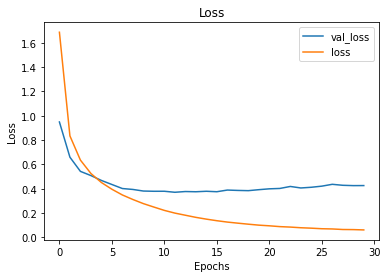

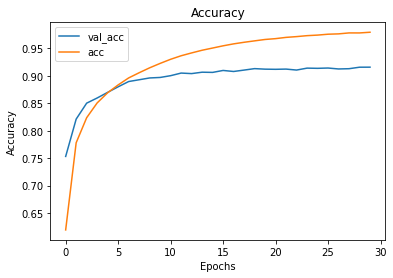

In [17]:
visualize_training_results(history)

In [18]:
print(classification_report(
    get_classes(y_test), 
    get_classes(model.predict(np.array([np.stack((img,)*3, axis=-1) for img in X_80_test])))
  )
)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       0.98      0.93      0.96       186
           2       0.60      0.61      0.60        69
           3       0.98      0.95      0.97       132
           4       0.91      0.85      0.88       358
           5       0.65      0.44      0.52        25
           6       0.67      0.56      0.61        39
           7       0.94      0.97      0.95       890
           8       0.93      0.98      0.96      1832
           9       0.88      0.96      0.92      1004
          10       0.84      0.72      0.78        96
          11       0.94      0.95      0.94       903
          12       0.90      0.90      0.90      2187
          13       0.92      0.97      0.95       947
          14       0.92      0.93      0.93      1147
          15       0.88      0.78      0.83        92
          16       0.89      0.92      0.90      1361
          17       0.88    